In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pydicom import dcmread
import os
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import re
from glob import glob
from wad import Dict
import cv2

In [2]:
DATA_ROOT="../datas/2_Domain_Adaptation_dataset/"
subjects=sorted(glob(DATA_ROOT+f"CT/*/",recursive=True))

In [3]:
import os
from os.path import join

In [69]:
def filt(tgt,str_list):
    return sorted([*filter(lambda x: tgt in x, str_list)])
mx=0
for sub in subjects:
    # get files
    src_dcm=sorted(glob(sub+f"**/*.dcm",recursive=True))
    src_png=sorted(glob(sub+f"**/*.png",recursive=True))
    
    # filter files, generate new file name
    src_f=Dict(img=filt("DICOM_anon",src_dcm),msk=filt("Ground",src_png))
    tmp=[m.split("/") for m in src_f.msk]
    new_dir=join(*tmp[0][:-2],"NewGT")
    os.makedirs(new_dir,exist_ok=True)
    new_fname=[join(new_dir,t[-1]) for t in tmp] ###
    # Image reading
    slices = [dcmread(d) for d in src_f.img]
    image=np.stack([s.pixel_array.astype("float") for s in slices])
    
    slope = float(slices[0].RescaleSlope)
    if slope != 1:
        image = (slope * image)
    if image.max()>mx:
        mx=image.max()
    image[image>5000]=0.
    image=image/(image[:,0,0].mean()+1e-8)
    image=image/(image.max()-image.min()) ###
    image=np.exp(image)/np.exp(1)
    
    # Mask   
    masks = np.stack([(cv2.imread(m)[...,0]==255).astype("uint8") for m in src_f.msk]) ###
    for name,img,msk in zip(new_fname,image,masks):
        # Thresholding the image
        _, thresh = cv2.threshold((img*255).astype("uint8"),117, 255, 0)
        # Find Trunk Contours, and sort with contour length
        contours_, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours=np.squeeze(sorted(contours_, key=len,reverse=True)[0])
        # Fill contour with 1
        filled_contour=cv2.fillPoly(np.zeros_like(img,dtype="uint8"), pts =[contours], color=1)
        i=0
        while filled_contour.sum()<np.prod(img.shape)/4:
            i+=1
            if i>2:
                print(name)
                break
            contours=np.squeeze(sorted(contours_, key=len,reverse=True)[i])
            filled_contour=cv2.fillPoly(np.zeros_like(img,dtype="uint8"), pts =[contours], color=1)
        # Find difference of trunk and liver
        trunk=np.logical_xor(msk,filled_contour)
        lung=msk>0
        msk[trunk]=32
        msk[lung]=63
        cv2.imwrite(name,msk)

In [61]:
sub="../datas/2_Domain_Adaptation_dataset/CT/16/"

src_dcm=sorted(glob(sub+f"**/*.dcm",recursive=True))
src_png=sorted(glob(sub+f"**/*.png",recursive=True))

# filter files, generate new file name
src_f=Dict(img=filt("DICOM_anon",src_dcm),msk=filt("Ground",src_png))
tmp=[m.split("/") for m in src_f.msk]
new_dir=join(*tmp[0][:-2],"NewGT")
os.makedirs(new_dir,exist_ok=True)
new_fname=[join(new_dir,t[-1]) for t in tmp] ###
# Image reading
slices = [dcmread(d) for d in src_f.img]
image=np.stack([s.pixel_array.astype("float") for s in slices])

slope = float(slices[0].RescaleSlope)
if slope != 1:
    image = (slope * image)
image[image>5000]=0.

image=image/(image[:,0,0].mean()+1e-8)
image=image/(image.max()-image.min()) ###
image=np.exp(image)/np.exp(1)
# Mask   
masks = np.stack([(cv2.imread(m)[...,0]==255) for m in src_f.msk]) ###
# for name,img,msk in zip(new_fname,image,masks):
#     # Thresholding the image
#     _, thresh = cv2.threshold((img*255).astype("uint8"), 140, 200, 0)
#     # Find Trunk Contours, and sort with contour length
#     contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     contours=np.squeeze(sorted(contours, key=len,reverse=True)[0])
#     # Fill contour with 1
#     filled_contour=cv2.fillPoly(np.zeros_like(img,dtype="uint8"), pts =[contours], color=1)

#     # Find difference of trunk and liver
#     trunk=np.logical_xor(msk,filled_contour)
    
#     lung=msk>0
#     msk[trunk]=32
#     msk[lung]=63
#     cv2.imwrite(name,msk)

In [62]:
image.max()

1.0

In [65]:
i=81
name,img,msk=new_fname[i],image[i],masks[i]
# Thresholding the image
_, thresh = cv2.threshold((img*255).astype("uint8"), 117, 200, 0)
# Find Trunk Contours, and sort with contour length
contours_, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours=np.squeeze(np.concatenate(sorted(contours_, key=len,reverse=True)[:1]))
# Fill contour with 1
filled_contour=cv2.fillPoly(np.zeros_like(img,dtype="uint8"), pts =[contours], color=1)
i=0
while filled_contour.sum()<np.prod(img.shape)/4:
    i+=1
    if i>2:
        print(name)
        break
    contours=np.squeeze(sorted(contours_, key=len,reverse=True)[i])
    filled_contour=cv2.fillPoly(np.zeros_like(img,dtype="uint8"), pts =[contours], color=1)

# Find difference of trunk and liver
trunk=np.logical_xor(msk,filled_contour)
lung=msk>0
msk[trunk]=32
msk[lung]=63
cv2.imwrite(name,msk)

True

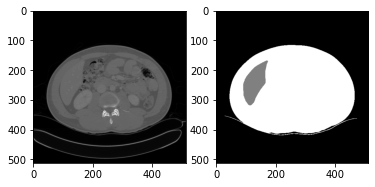

In [66]:
plt.subplot(1,2,1)
plt.imshow(img,"gray")
plt.subplot(1,2,2)
plt.imshow(msk,"gray")

In [67]:
contours=np.squeeze(sorted(contours_, key=len,reverse=True)[1])
# Fill contour with 1
filled_contour=cv2.fillPoly(np.zeros_like(img,dtype="uint8"), pts =[contours], color=1)


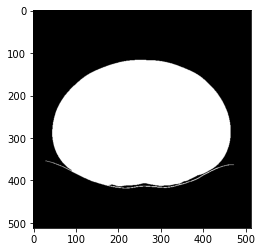

In [68]:
plt.imshow(filled_contour,"gray")